In [1]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import datetime

In [2]:
# --------------------------------------------------------------------------#
# adjust these lines to search for pictures of the fire you want to look at #
# you should not need to changed anything below this cell                   #
# --------------------------------------------------------------------------#

start_date = date(2020, 5, 22)
end_date = date(2020, 6, 22)
location = 'POINT (13.389 52.517)' # note that this is in the order longitude, latitude (or x, y)

In [3]:
# you need to set up the ~/.netrc in order for this login to work
api = SentinelAPI(None, None)

# the "footprint" is what we can use to preselect a certain area;
# the lake is at (51.7874, 14.4226)
# footprint = 'POLYGON((14.359428613281251 51.806620319822734,14.466545312500001 51.806620319822734,14.466545312500001 51.757343872357566,14.359428613281251 51.757343872357566,14.359428613281251 51.806620319822734))'

In [4]:
products = api.query(location,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(start_date, end_date),
                     cloudcoverpercentage=(0,30))

In [5]:
print('Found ' + str(len(products)) + ' results')

Found 8 results


In [6]:
products

OrderedDict([('d692a650-1806-4e9b-88d1-e824f976c3ea',
              {'title': 'S2A_MSIL2A_20200617T101031_N0214_R022_T32UQD_20200617T161854',
               'link': "https://scihub.copernicus.eu/apihub/odata/v1/Products('d692a650-1806-4e9b-88d1-e824f976c3ea')/$value",
               'link_alternative': "https://scihub.copernicus.eu/apihub/odata/v1/Products('d692a650-1806-4e9b-88d1-e824f976c3ea')/",
               'link_icon': "https://scihub.copernicus.eu/apihub/odata/v1/Products('d692a650-1806-4e9b-88d1-e824f976c3ea')/Products('Quicklook')/$value",
               'summary': 'Date: 2020-06-17T10:10:31.024Z, Instrument: MSI, Mode: , Satellite: Sentinel-2, Size: 767.32 MB',
               'beginposition': datetime.datetime(2020, 6, 17, 10, 10, 31, 24000),
               'endposition': datetime.datetime(2020, 6, 17, 10, 10, 31, 24000),
               'ingestiondate': datetime.datetime(2020, 6, 17, 21, 36, 5, 667000),
               'orbitnumber': 26045,
               'relativeorbitnumber

In [7]:
from collections import Counter

In [8]:
# to reduce download size, only download products for one tile
tiles = Counter([p['filename'].split('_')[5] for _, p in products.items()])
most_common_tile, amount = tiles.most_common(1)[0]
most_common_tile, amount

('T32UQD', 4)

In [9]:
# we create the directory structure we need for the following notebooks
! mkdir -p input/raster

In [10]:
api.download_all({k: v for k, v in products.items() if most_common_tile in v['filename']}, 'input/raster')

({'d692a650-1806-4e9b-88d1-e824f976c3ea': {'id': 'd692a650-1806-4e9b-88d1-e824f976c3ea',
   'title': 'S2A_MSIL2A_20200617T101031_N0214_R022_T32UQD_20200617T161854',
   'size': 804654613,
   'md5': 'DD4AE97AFAD2884F7FC49FDA65F6C653',
   'date': datetime.datetime(2020, 6, 17, 10, 10, 31, 24000),
   'footprint': 'POLYGON((12.344733794674134 52.21303032867289,12.346439703605412 52.217043860404544,12.408603762795623 52.36271559980042,12.470993716931147 52.50836314366547,12.533637922787934 52.653880456978825,12.596456783078388 52.79937966494399,12.659608391506955 52.944876790325615,12.72334134983589 53.09033052896263,12.765960837622682 53.18726097539074,13.634183017449221 53.1594219676414,13.531032170485291 52.17548471916956,12.344733794674134 52.21303032867289))',
   'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('d692a650-1806-4e9b-88d1-e824f976c3ea')/$value",
   'Online': True,
   'Creation Date': datetime.datetime(2020, 6, 17, 21, 37, 28, 209000),
   'Ingestion Date': date

## Previewing Downloaded Files

In [11]:
from glob import glob
downloaded = glob('input/raster/*.zip')

In [12]:
downloaded

['input/raster/S2A_MSIL2A_20200531T102031_N0214_R065_T32UQD_20200531T134031.zip',
 'input/raster/S2B_MSIL2A_20200602T100559_N0214_R022_T32UQD_20200602T135324.zip',
 'input/raster/S2B_MSIL2A_20200615T101559_N0214_R065_T32UQD_20200615T141117.zip',
 'input/raster/S2A_MSIL2A_20200617T101031_N0214_R022_T32UQD_20200617T161854.zip']

In [15]:
from pathlib import Path

import rasterio as r
from rasterio import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
Path(downloaded[1]).name

'S2B_MSIL2A_20200602T100559_N0214_R022_T32UQD_20200602T135324.zip'

In [36]:
import zipfile

def band_paths(p, bands, resolution=None):
    '''
    Given a zip file at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    The returned paths are formatted in the zip scheme as per Apache Commons VFS and can
    thus be directly opened by rasterio.
    '''
    with zipfile.ZipFile(p) as f:
        files = f.namelist()
        rasters = [f for f in files if f.endswith('.jp2')]
        rasters = ['zip+file://' + p + '!/' + r for r in rasters for b in bands if b in r and (not resolution or resolution in r)]
        return sorted(rasters)

In [37]:
def rgb_paths(zip_file, resolution='10m'):
    return band_paths(zip_file, ['B02', 'B03', 'B04'], resolution)

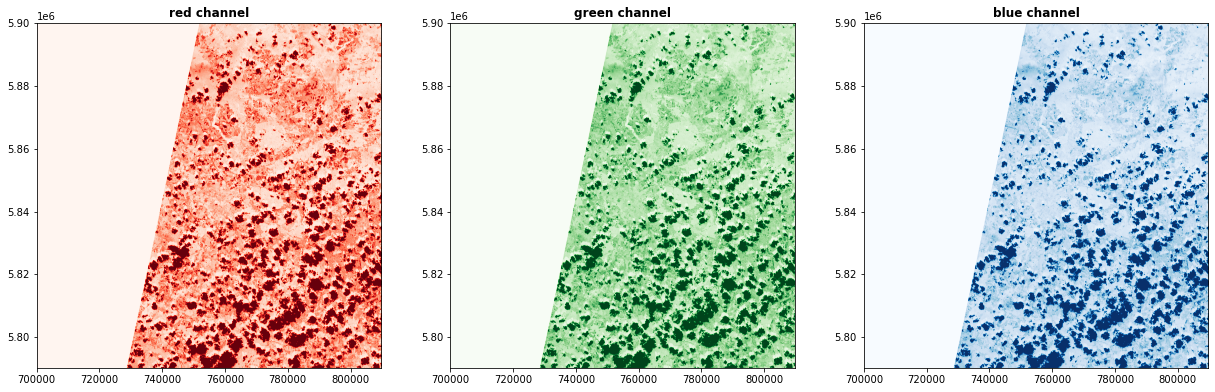

In [38]:
# preview the first downloaded image
with r.open(band_paths(downloaded[3], ['TCI'], '20m')[0]) as true_color:
    # we do not need
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
    plot.show((true_color, 1), ax=axr, cmap='Reds', title='red channel')
    plot.show((true_color, 2), ax=axg, cmap='Greens', title='green channel')
    plot.show((true_color, 3), ax=axb, cmap='Blues', title='blue channel')
    plt.show()

In [39]:
# plotting the combined rgb image
true_color = r.open(band_paths(downloaded[3], ['TCI'], '20m')[0])

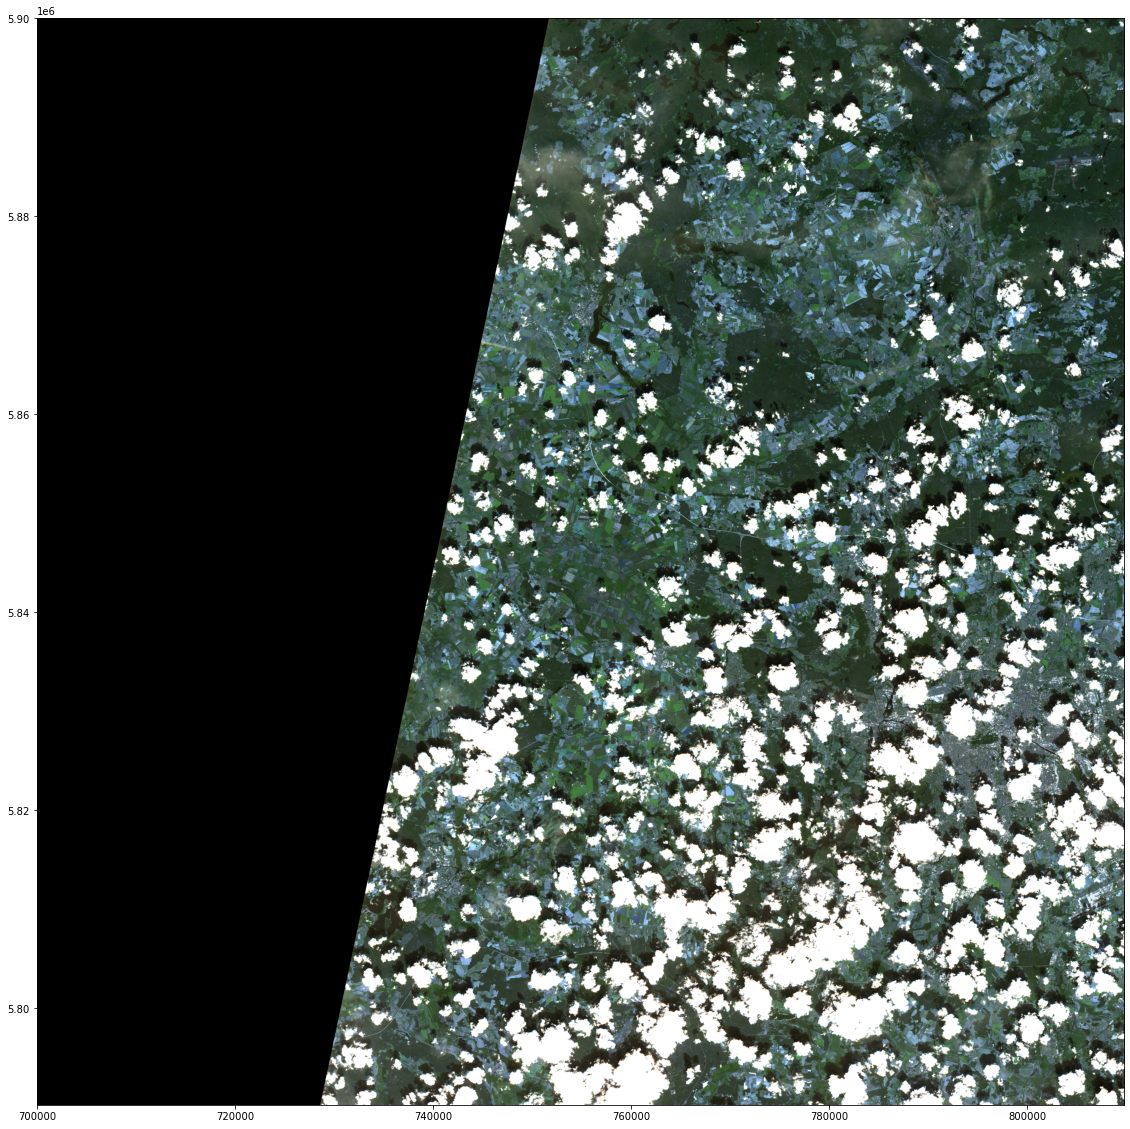

In [40]:
# note that in order to get the real colors, we need to reverse the bands into "rasterio band order"
fig, (ax) = plt.subplots(1, 1, figsize=(20,20))
plot.show(true_color.read()[::-1], transform=true_color.transform, ax=ax)
plt.show()

## Creating Your Own Composite Image

In [41]:
import numpy as np

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


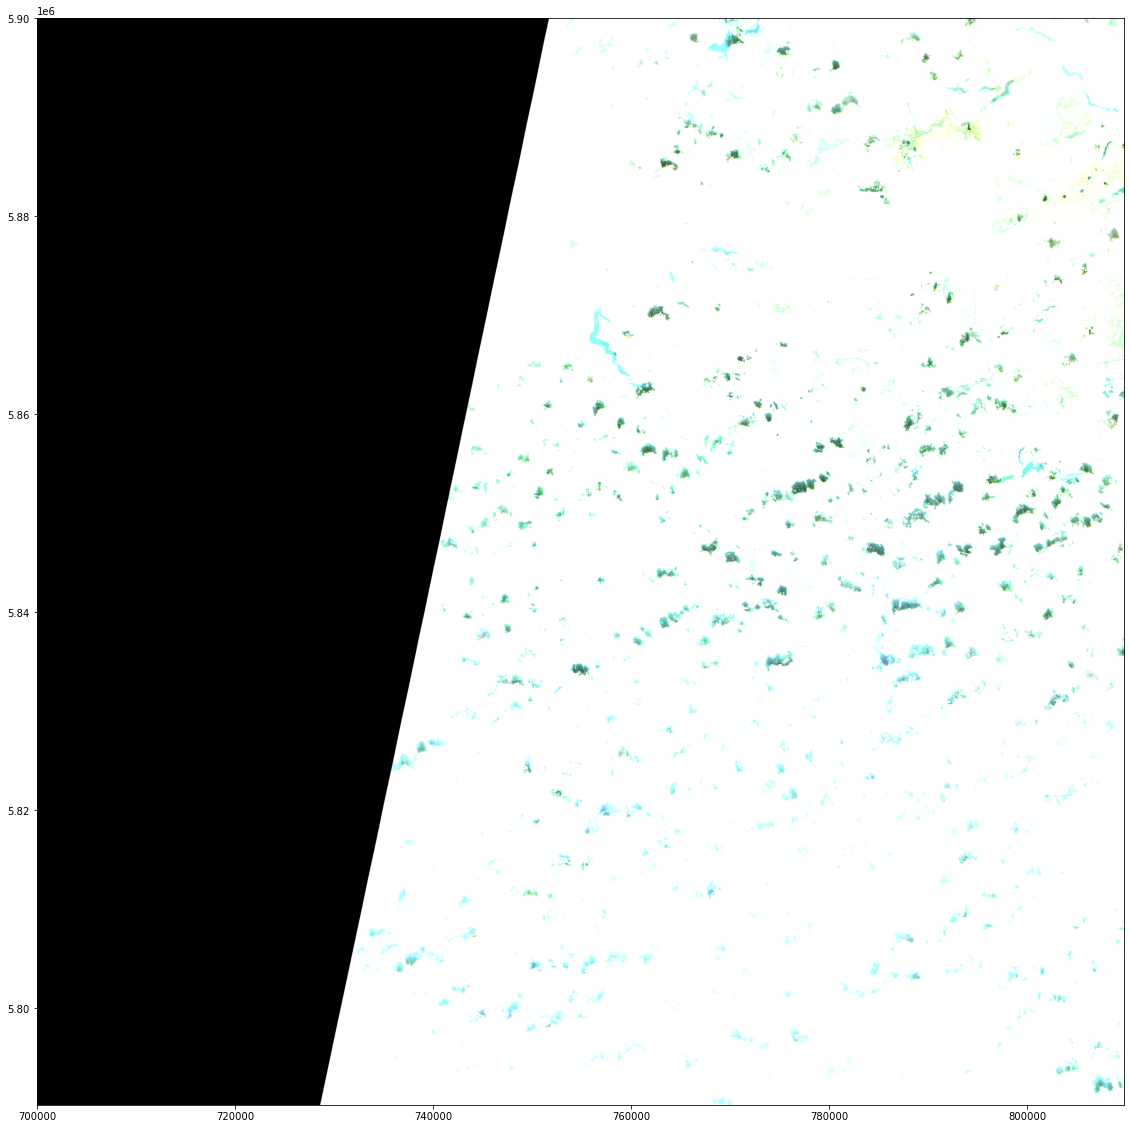

In [42]:
b02, b03, b04 = band_paths(downloaded[3], ['B02', 'B03', 'B04'], '20m')
with r.open(b02) as blue, r.open(b03) as green, r.open(b04) as red:
    fig, (ax) = plt.subplots(1, 1, figsize=(20,20))
    plot.show([red.read(1), green.read(1), blue.read(1)], transform=blue.transform, ax=ax)
    plt.show()

In [43]:
# note that the BGR images have a different range.
blue = r.open(b02).read(1)

In [44]:
np.min(blue), np.max(blue)

(0, 18366)

In [45]:
green = r.open(b03).read(1)
red = r.open(b04).read(1)

np.min(green), np.max(green)

(0, 17308)

In [46]:
np.min(red), np.max(red)

(0, 16604)

In [47]:
np.nanpercentile(blue, (0,95))

array([   0., 6612.])

We can find some information about how the TCI images are created [here](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/definitions). Particularly interesting is the following quote:

>  The TCI is an RGB image built from the B02 (Blue), B03 (Green), and B04 (Red) Bands. The reflectances are coded between 1 and 255, 0 being reserved for 'No Data'. The saturation level of 255 digital counts correspond to a level of 3558 for L1C products or 2000 for L2A products (0.3558 and 0.2 in reflectance value respectively.

In [48]:
red_cleaned = np.where(red <= 2000, red, np.nan) / 2000
green_cleaned = np.where(green <= 2000, green, np.nan) / 2000
blue_cleaned = np.where(blue <= 2000, blue, np.nan) / 2000

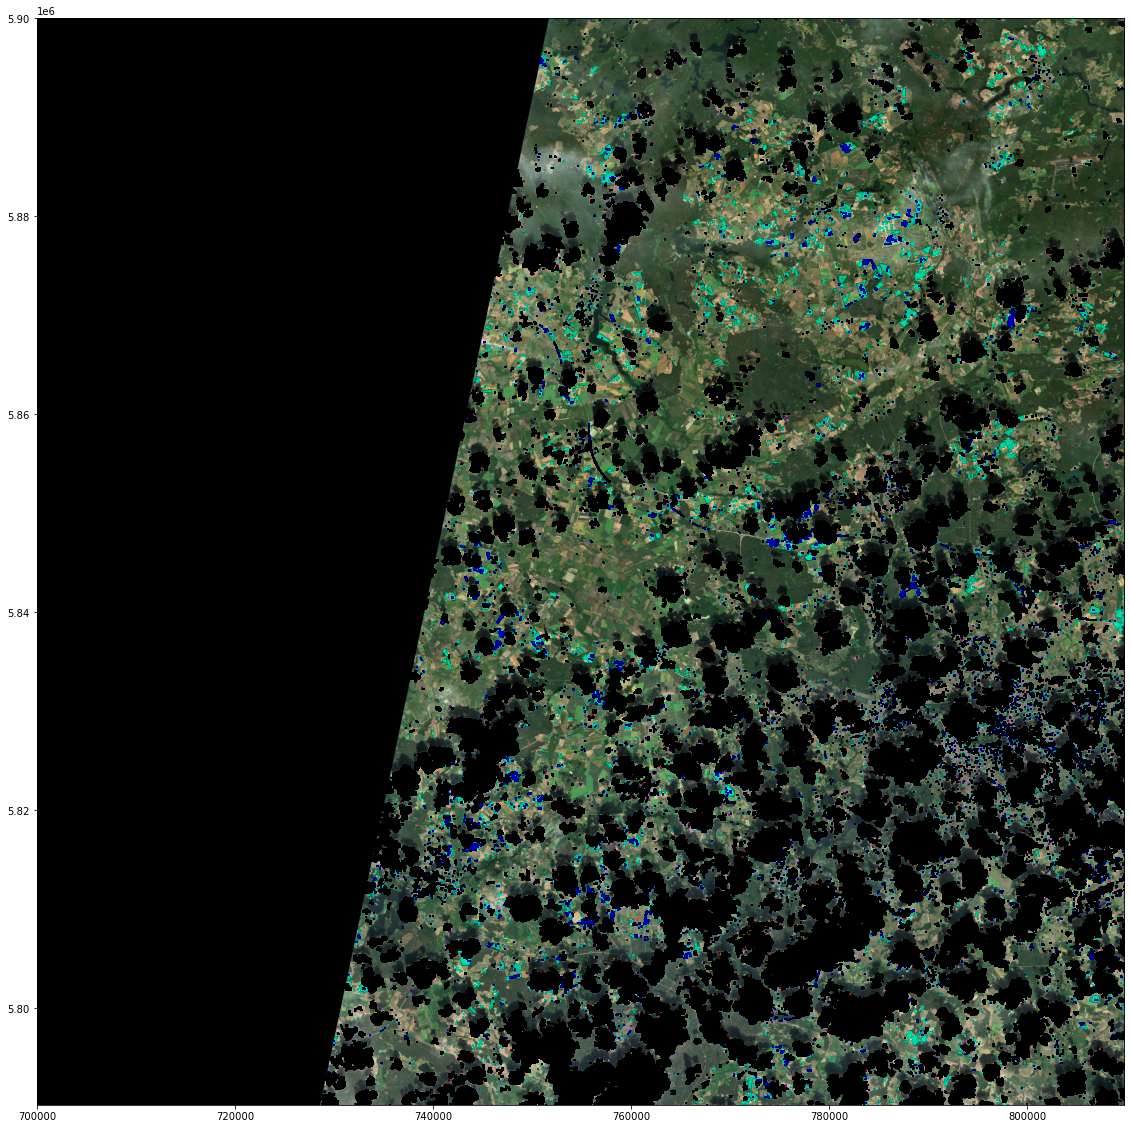

In [49]:
transform = r.open(b02).transform
plt.figure(figsize=(20,20))
plot.show([red_cleaned, green_cleaned, blue_cleaned], transform=transform)

A-ha! The out of range values appear to be clouds.

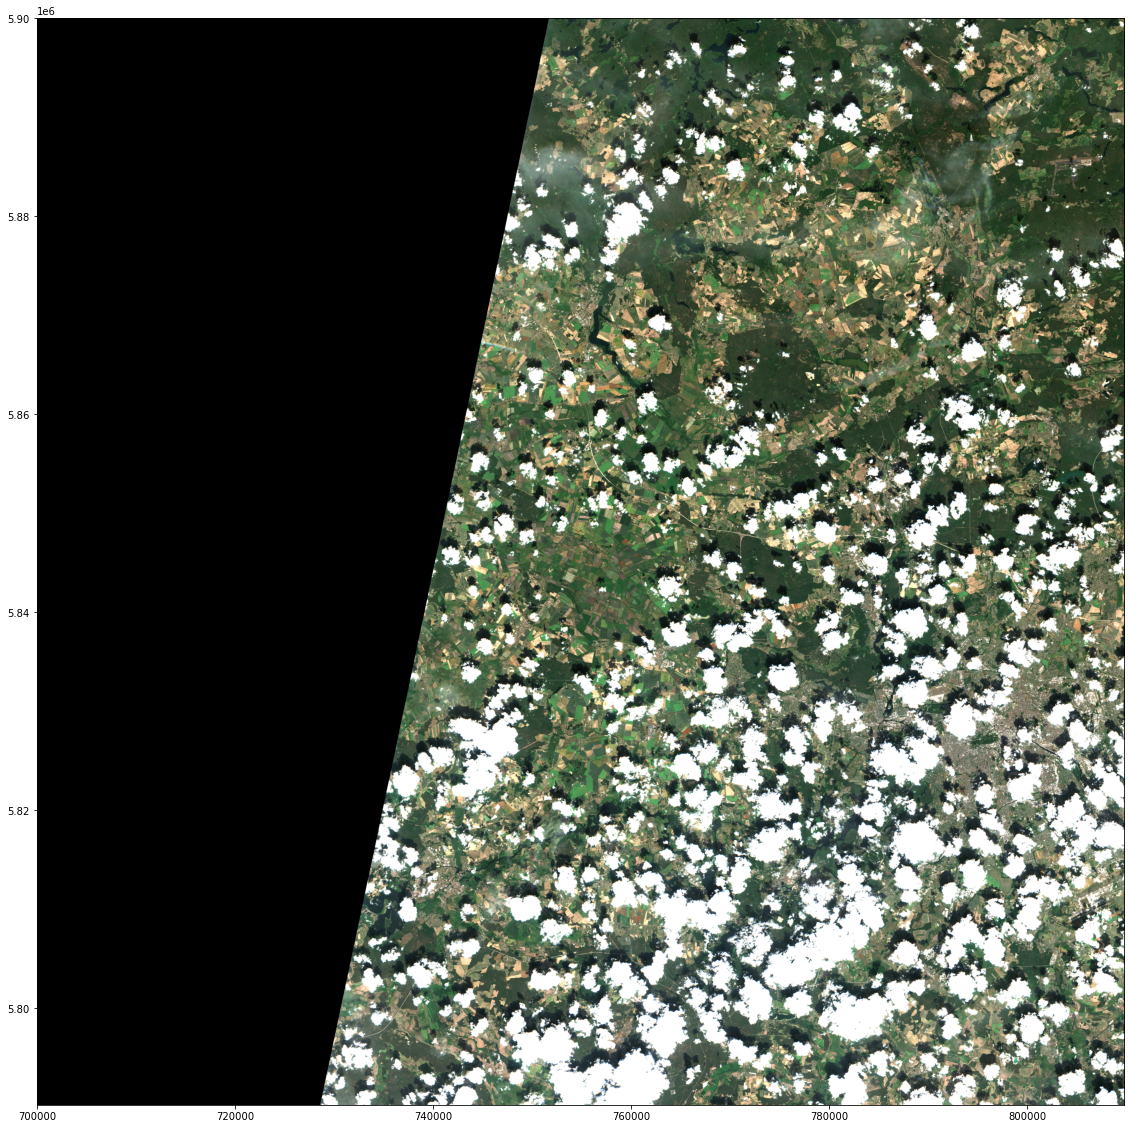

In [50]:
plt.figure(figsize=(20,20))
plot.show([np.clip(red, 0, 2000) / 2000, np.clip(green, 0, 2000) / 2000, np.clip(blue, 0, 2000) / 2000], transform=transform)